## Heart disease patients clasterization
Tymoteusz Urban, Karolina Mączka

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import train_test_split

In [30]:
import warnings
warnings.filterwarnings("ignore")

### Dividing dataset and saving to files

In [31]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('heart_disease_patients.csv')

# Split data into train and remaining data
X_train, X_remaining = train_test_split(df, test_size=0.3, random_state=42)

# Split remaining data into test and validation sets
X_test, X_validation = train_test_split(X_remaining, test_size=0.5, random_state=42)

train_df = pd.DataFrame(X_train) 
train_df.to_csv('train.csv', index=False)

test_df = pd.DataFrame(X_test)  
test_df.to_csv('test.csv', index=False)

validation_df = pd.DataFrame(X_validation)
validation_df.to_csv('validation.csv', index=False)


## Data exploration

In [32]:
df = pd.read_csv('train.csv')
df.drop('id', axis=1, inplace=True)
raw_data = df
print(df.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope
0   65    1   1       138   282    1        2      174      0      1.4      2
1   62    1   4       120   267    0        0       99      1      1.8      2
2   57    1   3       150   168    0        0      174      0      1.6      1
3   57    1   4       140   192    0        0      148      0      0.4      2
4   58    0   4       100   248    0        2      122      0      1.0      2


1. age - age in years
2. sex - sex (1 = male; 0 = female)
3. cp - chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 4 = asymptomatic)
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)
5. chol - serum cholestoral in mg/dl
6. fbs - fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
7. restecg - resting electrocardiographic results (0 = normal; 1 = having ST-T; 2 = hypertrophy)
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest
11. slope - the slope of the peak exercise ST segment (1 = upsloping; 2 = flat; 3 = downsloping)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        303 non-null    int64  
 1   age       303 non-null    int64  
 2   sex       303 non-null    int64  
 3   cp        303 non-null    int64  
 4   trestbps  303 non-null    int64  
 5   chol      303 non-null    int64  
 6   fbs       303 non-null    int64  
 7   restecg   303 non-null    int64  
 8   thalach   303 non-null    int64  
 9   exang     303 non-null    int64  
 10  oldpeak   303 non-null    float64
 11  slope     303 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 28.5 KB


In [5]:
df.isnull().sum()

id          0
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
dtype: int64

There are no null values, all variables are clean and properly encoded

array([[<Axes: title={'center': 'id'}>, <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'sex'}>],
       [<Axes: title={'center': 'cp'}>,
        <Axes: title={'center': 'trestbps'}>,
        <Axes: title={'center': 'chol'}>],
       [<Axes: title={'center': 'fbs'}>,
        <Axes: title={'center': 'restecg'}>,
        <Axes: title={'center': 'thalach'}>],
       [<Axes: title={'center': 'exang'}>,
        <Axes: title={'center': 'oldpeak'}>,
        <Axes: title={'center': 'slope'}>]], dtype=object)

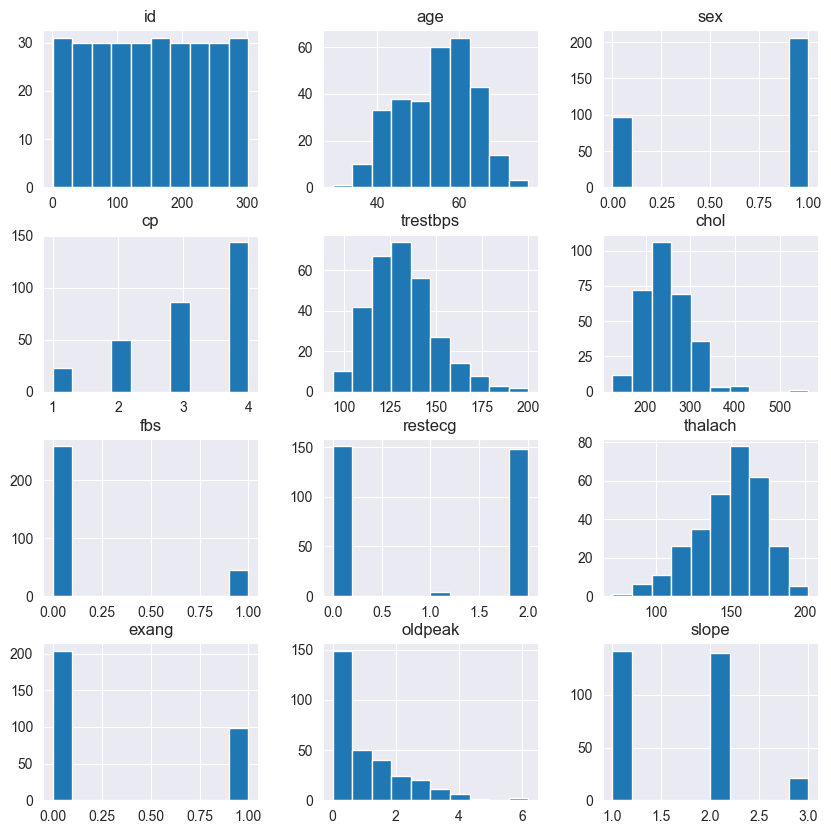

In [6]:
df.hist(figsize=(10,10))

<Axes: >

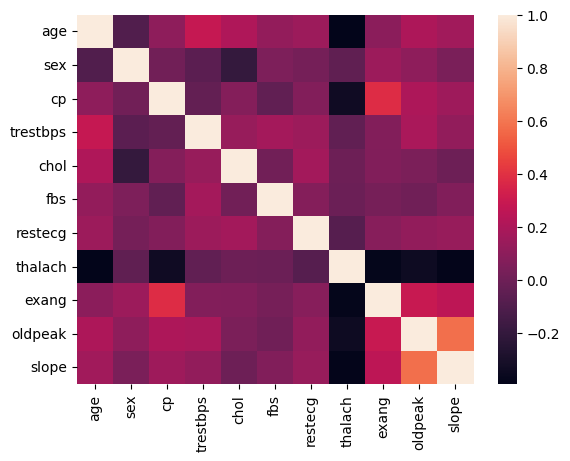

In [14]:
sns.heatmap(df.corr())

There is quite high correlation between oldpeak and slope and also between cp and exang, but is it big enough to delete any of the columns?

In [33]:
print(f"oldpeak and slope correlation: {df[['oldpeak', 'slope']].corr().iloc[0,1]}")
print(f"cp and exang correlation: {df[['cp', 'exang']].corr().iloc[0,1]}")

oldpeak and slope correlation: 0.5458278072906251
cp and exang correlation: 0.39916290470356114


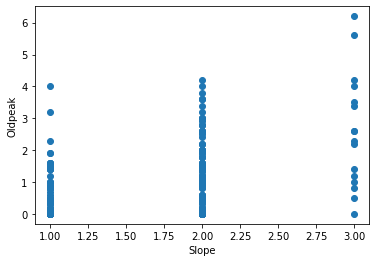

In [34]:
plt.scatter(df['slope'], df['oldpeak'])
plt.xlabel('Slope')
plt.ylabel('Oldpeak')
plt.show()

In [35]:
# Another approach
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

In [36]:
calc_vif(df)

NameError: name 'variance_inflation_factor' is not defined

Which variables should we drop? According to traditional correlation between variables it could be slope, but after calculatin VIF it seems that age, trestbps, chol and thalach are highly correlated with the other variables.

## Preprocessing

In [37]:
# Outliers removal - replace lower_bound and upper_bound, only numeric columns
def replace_outliers(data, k=1.5):
    """
    Removes outliers from a pandas DataFrame using the interquartile range (IQR) method.

    :param data: dataframe
    :param k: A multiplier to adjust the outlier threshold. By default, k is set to 1.5.
    :return: dataframe
    """
    for col in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']:
        q1, q3 = np.percentile(data[col], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - k * iqr
        upper_bound = q3 + k * iqr
        mask = (data[col] < lower_bound)
        data.loc[mask, col] = lower_bound
        mask = (data[col] > upper_bound)
        data.loc[mask, col] = upper_bound
    return data

In [38]:
replace_outliers(df)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,65.0,1,1,138.00,282.0,1,2,174.0,0,1.4,2
1,62.0,1,4,120.00,267.0,0,0,99.0,1,1.8,2
2,57.0,1,3,150.00,168.0,0,0,174.0,0,1.6,1
3,57.0,1,4,140.00,192.0,0,0,148.0,0,0.4,2
4,58.0,0,4,100.00,248.0,0,2,122.0,0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...
207,54.0,1,2,171.25,283.0,0,2,195.0,0,0.0,1
208,67.0,1,4,125.00,254.0,1,0,163.0,0,0.2,2
209,59.0,1,4,140.00,177.0,0,0,162.0,1,0.0,1
210,61.0,1,4,140.00,207.0,0,2,138.0,1,1.9,1


In [39]:
# Instead manual deletion of variables we could use PCA for reducing dimensionality
def remove_overshadowing(data):
    """
    Performs Principal Component Analysis (PCA) on a given dataset.

    :param data: dataframe
    :return:
            A reduced version of the input DataFrame, containing the first n principal components
            where n is the smallest number of components that explain at least 95% of the variance in the data.
            The columns of the new DataFrame are named "PC1", "PC2", etc.

    """
    # Perform PCA
    pca = PCA()
    X_pca = pca.fit_transform(data)

    # Determine the number of principal components to retain
    explained_variances = pca.explained_variance_ratio_
    cumulative_variances = np.cumsum(explained_variances)
    n_components = np.argmax(cumulative_variances > 0.95) + 1

    # Retain the first n principal components
    X_reduced = X_pca[:, :n_components]

    # Convert back to a pandas DataFrame
    df_reduced = pd.DataFrame(X_reduced, columns=["PC"+str(i) for i in range(1, n_components+1)])
    
    return df_reduced

We will also need to scale our data - we can try 3 different ways to do it. We will test it later.

In [40]:
def standarize(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns)
    return X


def normalize(X):
    normalizer = Normalizer()
    X_normalized = normalizer.fit_transform(X)
    X = pd.DataFrame(X_normalized, columns=X.columns)
    return X


def minmax(X):
    minmaxer = MinMaxScaler()
    X_scaled = minmaxer.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    return X

## Number of clusters

In [41]:
# We will use functions from other python files, so we don't have to run whole notebook every time
from Preprocessing import standarize, minmax, normalize, replace_outliers, preprocessing
from KMeans import k_means_alg

First we prepare methods for finding optimal number of clusters

In [42]:
def num_of_clus_elbow(data) -> int:
    """
        Finds optimal number of clusters using elbow method.

        :param data: dataframe
        :return: number of clusters
    """
    sum_of_squared_distances = []
    K = range(1, 10)
    for num_clusters in K:
        kmeans = KMeans(n_clusters=num_clusters, n_init=10)
        kmeans.fit(data)
        sum_of_squared_distances.append(kmeans.inertia_)

    # finding elbow point
    sd = np.diff(sum_of_squared_distances, 2)
    elbow_point = np.argmax(sd) + 2

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 10), sum_of_squared_distances, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    return elbow_point

In [43]:
def num_of_clus_silhouette(data) -> int:
    """
    Finds optimal number of clusters using silhouette method.

    :param data: dataframe
    :return: number of clusters
    """
    silhouette_scores = []
    for i in range(2, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)

    silhouette_point = np.argmax(silhouette_scores) + 2

    plt.figure(figsize=(8, 5))
    plt.plot(range(2, 11), silhouette_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.show()

    return silhouette_point

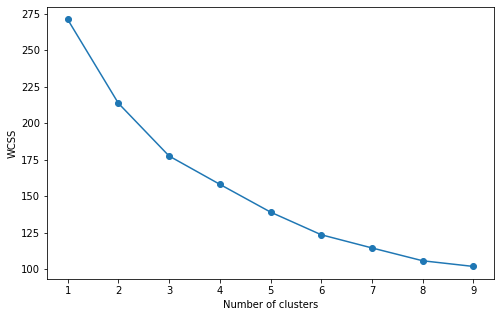

Elbow method: 2


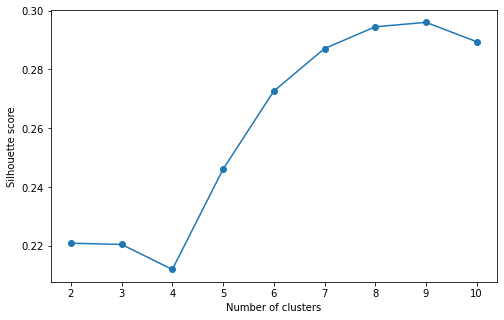

Silhouette method: 9


In [44]:
# Let's check elbow method
df_clusters = replace_outliers(raw_data)
df_clusters = minmax(df_clusters)
print('Elbow method:', num_of_clus_elbow(df_clusters))
print('Silhouette method:', num_of_clus_silhouette(df_clusters))

We can see that returned values are different. Now we can test it on a baseline model:

In [48]:
for i in [2,10]:
    dfkmeans, model = k_means_alg(df_clusters, num_clusters=i)
    y_kmeans = dfkmeans['label']
    print(f"silhouette score: {silhouette_score(df_clusters, y_kmeans)}")
    print(f"calinski harabasz score: {calinski_harabasz_score(df_clusters, y_kmeans)}")
    print(f"davies bouldin score: {davies_bouldin_score(df_clusters, y_kmeans)}")

number of clusters: 2
silhouette score: 0.3244921718518941
calinski harabasz score: 103.18449273926495
davies bouldin score: 1.3148329552292006
number of clusters: 10
silhouette score: 0.5251210202793916
calinski harabasz score: 422.0801221567947
davies bouldin score: 0.7597040199846796


Results vary depending on the score used, but overall results are better for 10 clusters. On the other hand, 10 clusters is too much, and we can try using something between for example 5. Now let's check how preprocessing influences clusters and score.

In [49]:
processing = ['stand', 'minmax', 'norm']
for proc in processing:
    print(f'Processing: {proc}')
    df_proc = preprocessing(raw_data, rem_over=False, process=proc)
    dfkmeans, model = k_means_alg(df_proc, num_clusters=5)
    y = dfkmeans['label']
    print(f"silhouette score: {silhouette_score(df_proc, y)}")
    print(f"calinski harabasz score: {calinski_harabasz_score(df_proc, y)}")
    print(f"davies bouldin score: {davies_bouldin_score(df_proc, y)}")

Processing: stand
number of clusters: 5
silhouette score: 0.197985520103713
calinski harabasz score: 40.04214577817302
davies bouldin score: 1.6292233326573335
Processing: minmax
number of clusters: 5
silhouette score: 0.3979121178589119
calinski harabasz score: 184.17459876807794
davies bouldin score: 1.0227573410383086
Processing: norm
number of clusters: 5
silhouette score: 0.9182733788441707
calinski harabasz score: 24797.027141052153
davies bouldin score: 0.11888807810511795


We can see that number of clusters vary. Normalizer has the best results, but we can see that normalized data is hard to interpret:

In [50]:
normalize(raw_data).head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,0.178178,0.002741,0.002741,0.378285,0.773018,0.002741,0.005482,0.476968,0.000000,0.003838,0.005482
1,0.196692,0.003172,0.012690,0.380695,0.847046,0.000000,0.000000,0.314073,0.003172,0.005710,0.006345
2,0.196362,0.003445,0.010335,0.516742,0.578751,0.000000,0.000000,0.599421,0.000000,0.005512,0.003445
3,0.199493,0.003500,0.014000,0.489983,0.671977,0.000000,0.000000,0.517983,0.000000,0.001400,0.007000
4,0.193573,0.000000,0.013350,0.333747,0.827693,0.000000,0.006675,0.407171,0.000000,0.003337,0.006675


For example values in sex column are around 0.003 while in chol ot thalach values are way bigger. Thus, minmax scaler is the most reasonable scaler, but even 5 clusters is quite a lot. Let's check it with some other numbers of clusters taken from elbow and silhouette plots:

In [53]:
for i in [2, 3, 4, 5, 10]:
    df_minmax = preprocessing(raw_data, rem_over=False, process='minmax')
    dfkmeans, model = k_means_alg(df_minmax, num_clusters=i)
    y_kmeans = dfkmeans['label']
    print(f"silhouette score: {silhouette_score(df_minmax, y_kmeans)}")
    print(f"calinski harabasz score: {calinski_harabasz_score(df_minmax, y_kmeans)}")
    print(f"davies bouldin score: {davies_bouldin_score(df_minmax, y_kmeans)}")

number of clusters: 2
silhouette score: 0.3244921718518941
calinski harabasz score: 103.18449273926495
davies bouldin score: 1.3148329552292004
number of clusters: 3
silhouette score: 0.3569914309141545
calinski harabasz score: 136.85203655097763
davies bouldin score: 1.1764582174008054
number of clusters: 4
silhouette score: 0.39200711543098427
calinski harabasz score: 171.10798515809935
davies bouldin score: 1.0458506223110238
number of clusters: 5
silhouette score: 0.3979121178589119
calinski harabasz score: 184.17459876807794
davies bouldin score: 1.0227573410383086
number of clusters: 10
silhouette score: 0.5202903663302814
calinski harabasz score: 465.8686769255458
davies bouldin score: 0.8360245158382101


On average the more clusters the better the results, but we have to draw a line somewhere and pick apropriate number of clusters. Last question is if we should use PCA for reducing dimensionality.

In [54]:
df_pca = preprocessing(raw_data, process='minmax')
dfkmeans, model = k_means_alg(df_pca, num_clusters=3)
y_kmeans = dfkmeans['label']
print(f"silhouette score: {silhouette_score(df_pca, y_kmeans)}")
print(f"calinski harabasz score: {calinski_harabasz_score(df_pca, y_kmeans)}")
print(f"davies bouldin score: {davies_bouldin_score(df_pca, y_kmeans)}")

number of clusters: 3
silhouette score: 0.3709004234122623
calinski harabasz score: 150.05801804112986
davies bouldin score: 1.1569905391889457


Some scores have improved a little bit, and it is easier to visualize clustering as we only have 3 variables, but we lose interpretability which is crucial in medical data analysis. That said in preprocessing we will stick to minmax scaler and outliers removal, and we will be using 3 clusters.

## Algorithms

In [5]:
from KMeans import mean_inclust_dist, std_dev_of_inclust_dist

In [18]:
df_scores = preprocessing(raw_data, rem_over=False, process='minmax')
dfkmeans, model = k_means_alg(df_scores, num_clusters=3)
df_without_labels = dfkmeans.drop("label", axis=1)
print(mean_inclust_dist(df_without_labels, y_scores))
print(std_dev_of_inclust_dist(df_scores, y_scores))

number of clusters: 3
1.225302365784205
0.07406982949090163


In [9]:
# To be continued ...

In [26]:
from OtherAlgorithms import dbscan

In [55]:
processing = ['stand', 'norm', 'minmax']
data = df
for proc in processing:
    print('-----')
    print(f'Processing: {proc}')
    df = preprocessing(data, rem_over=True, process=proc)
    df_with_labels, model = dbscan(df, proc)
    df_without_labels = df_with_labels.drop("label", axis=1)
    y = df_with_labels['label']
    print(f"silhouette score: {silhouette_score(df_without_labels, y)}")
    print(f"calinski harabasz score: {calinski_harabasz_score(df_without_labels, y)}")
    data_with_labels = data.copy()
    data_with_labels['label'] = df_with_labels['label']
    print(medians_for_clusters(data_with_labels))

-----
Processing: stand
silhouette score: 0.12917573461018567
calinski harabasz score: 8.52246172390958
        age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
label                                                                           
-1     62.0  1.0  2.0    150.00  240.0  0.0      2.0    130.0    0.0     1.00   
 0     60.5  0.5  1.0    142.50  290.5  1.0      2.0    159.5    0.0     1.10   
 1     54.0  1.0  3.0    130.00  241.5  0.0      0.0    153.5    0.0     0.55   
 2     57.5  1.0  3.0    130.00  215.0  1.0      0.0    154.0    0.0     1.00   
 3     58.0  0.0  4.0    171.25  228.0  1.0      2.0    146.0    1.0     2.80   

       slope  
label         
-1       2.0  
 0       1.5  
 1       1.5  
 2       2.0  
 3       2.0  
-----
Processing: norm
silhouette score: 0.3270818782889221
calinski harabasz score: 17.191742142747167
        age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
label                                 